A couple months ago I adpted a Bayesian Heirarchical model to work for the NHL. Since then several friends have told me to use my model to win big at sports betting. They're clearly more confident in my model than I am. Their eagerness got me thinking though: Could my model actually succeed at such a task?
s
Sports betting is legal in Canada, with several games available directly through our provincial lottery commissions. This post will focus on one game called Pools. Pools simply provides a 'card' with between 7 and 15 NHL games on it. The goal of the game is simply to predict the winner in each of those games. The player who gets the most games correct then wins the pool. In the event of multiple winners tied for most games correct, the pool is split equally among them.

In [1]:
# Import all of the libraries needed for this post
import requests
import json
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import theano
from itertools import combinations

/home/everett/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
# A function that retrieves the game data from the NHL stats API
# for a selected date range.
def request_game_data(start_date, end_date):
    base_url = 'https://statsapi.web.nhl.com'
    path = '/api/v1/schedule?startDate='+start_date+\
            '&endDate='+end_date+'&expand=schedule.linescore'
    response = requests.get(base_url + path)
    return response.json()

# A function to extract the relevant data from the schedule
# and return it as a pandas dataframe
def extract_game_data(schedule):
    """Given full JSON records for games from the NHL API,
    returns a simplified list of just the data we need.
    """
    games = pd.DataFrame(columns=['game_pk',
                                  'date',
                                  'season',
                                  'game_type',
                                  'home_team',
                                  'home_team_reg_score',
                                  'home_team_fin_score',
                                  'away_team',
                                  'away_team_reg_score',
                                  'away_team_fin_score',
                                  'went_to_shoot_out'
                                  ])

    for date_obj in schedule['dates']:
        date = date_obj['date'];
        for game_obj in date_obj['games']:
            game_pk = game_obj['gamePk'] 
            game_type = game_obj['gameType']
            season = game_obj['season']
            home_team_obj = game_obj['teams']['home']
            away_team_obj = game_obj['teams']['away']

            home_team = home_team_obj['team']['name']
            home_team_fin_score = home_team_obj['score']

            away_team = away_team_obj['team']['name']
            away_team_fin_score = away_team_obj['score']

            detailed_score_data = game_obj['linescore']
            period_data = detailed_score_data['periods']
            shootout_data = detailed_score_data['shootoutInfo']

            home_team_reg_score = 0
            away_team_reg_score = 0

            for period in period_data[0:3]:
                home_team_reg_score += period['home']['goals']
                away_team_reg_score += period['away']['goals']

            went_to_shoot_out = (shootout_data['home']['attempts'] != 0 or
                                 shootout_data['away']['attempts'] != 0)

            games = games.append({'game_pk': game_pk,
                                  'date': date,
                                  'season': season,
                                  'game_type': game_type,
                                  'home_team': home_team,
                                  'home_team_reg_score': home_team_reg_score,
                                  'home_team_fin_score': home_team_fin_score,
                                  'away_team': away_team,
                                  'away_team_reg_score': away_team_reg_score,
                                  'away_team_fin_score': away_team_fin_score,
                                  'went_to_shoot_out': went_to_shoot_out
                                  }, ignore_index=True)

    return games

completed_game_data = request_game_data('2015-09-18', '2018-04-29')
completed_games = extract_game_data(completed_game_data)
completed_games['date'] =  pd.to_datetime(completed_games['date'])
#completed_games.to_csv('completed_games.csv', index = False)

In [6]:
completed_games.head()

,game_pk,date,season,game_type,home_team,home_team_reg_score,home_team_fin_score,away_team,away_team_reg_score,away_team_fin_score,went_to_shoot_out
0,2015010002,2015-09-20,20152016,PR,Nashville Predators,5,5,Florida Panthers,2,2,False
1,2015010001,2015-09-20,20152016,PR,Boston Bruins,2,2,New Jersey Devils,0,0,False
2,2015010003,2015-09-20,20152016,PR,Nashville Predators,2,2,Florida Panthers,2,3,False
3,2015010006,2015-09-21,20152016,PR,Columbus Blue Jackets,0,0,Pittsburgh Penguins,0,1,True
4,2015010009,2015-09-21,20152016,PR,New York Islanders,3,3,Philadelphia Flyers,2,2,False


In [7]:
cards = pd.read_csv('POOLS-cards.csv', converters={'payout': lambda s: float(s.replace('$', '').replace(',', ''))})
cards['date'] =  pd.to_datetime(cards['date'])
cards['closed'] = pd.to_datetime(cards['closed'])
card_results = pd.read_csv('POOLS-card-results.csv')
card_results.head()

# We need to connect the game IDs to the sport-select games. 
# Expand the team names on the cards to match the nhl data
pools_to_nhl_team_names = pd.read_csv('pools_to_nhl_team_names.csv')
card_results = card_results.merge(pools_to_nhl_team_names, 
                                  left_on='visitor', 
                                  right_on='Pools_Team', 
                                  how='left')
card_results.rename(index=str, columns={'NHL_Team':'visitor_full'}, inplace=True)
card_results.drop(['Pools_Team'], axis=1, inplace=True)
card_results = card_results.merge(pools_to_nhl_team_names, 
                                  left_on='home', 
                                  right_on='Pools_Team', 
                                  how='left')
card_results.rename(index=str, columns={'NHL_Team':'home_full'}, inplace=True)
card_results.drop(['Pools_Team'], axis=1, inplace=True)
card_results.head()

# Join the close date to the card_results to aid in this
card_results = card_results.merge(cards[['date', 'closed', 'card']], on='card', how='left')

In [8]:
# Find the game_pk for the nhl data game that is after the close date,
# but before the card date.
def find_game_pk(game):
    # Check if the game was postponed
    if pd.isnull(game.result):
        return None
    
    # NHL games
    less_than_date = completed_games.date <= game.date
    greater_than_closed = completed_games.date >= game.closed
    home_team = completed_games.home_team == game.home_full
    away_team = completed_games.away_team == game.visitor_full
    candidate_games = completed_games[less_than_date & greater_than_closed &
                                      home_team & away_team]
    assert(candidate_games.shape[0] > 0)
    
    # Pools Card Games
    card_number = game.card
    card_games = card_results[card_results['card'] == card_number]
    candidate_card_games = card_games[(card_games.visitor == game.visitor) &
                                      (card_games.home == game.home)]
    assert(candidate_card_games.shape[0] > 0)
    
    # Check if this is the first, second, third, fourth game matching the criteria
    row = candidate_card_games.loc[candidate_card_games['game_number']==game.game_number].reset_index().index[0]
    candidate_games = candidate_games.iloc[row, :]
    return candidate_games['game_pk']

card_results['game_pk'] = card_results.apply(lambda row: find_game_pk(row), axis=1)

In [9]:
# Filter the games to only consider the 2015-2016 season onwards, and only 
# preseason, regular season, and playoff games
completed_games = completed_games[(completed_games.game_type.isin(['PR','R', 'P']) &
                                  completed_games['season'].isin(['20152016', '20162017', '20172018']))]

In [10]:
# Extract the unique list of teams and assign an integer label to each one
teams = completed_games.home_team.unique()
teams = np.sort(teams)
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index

# Create a unique list of each team combination and assign an integer label
# to each one. Also decide which team will be 'heads' in each pair.
all_teams_pair_combinations = combinations(teams['team'], 2)
team_pairs_dict = {}
team_pairs_heads_dict = {}
pair_index = 0
for pair in all_teams_pair_combinations:
    team_pairs_dict[(pair[0], pair[1])] = pair_index
    team_pairs_dict[(pair[1], pair[0])] = pair_index
    team_pairs_heads_dict[(pair[0], pair[1])] = pair[0]
    team_pairs_heads_dict[(pair[1], pair[0])] = pair[0]
    pair_index += 1

# Determine the total number of teams and team pairs for PYMC3
num_teams = teams.shape[0]
num_team_pairs  = len(team_pairs_dict)//2
    
# Determine if the ultimate winner of the game was the heads team 
# (Bernoulli outcome = True) or the tails team (Bernoulli outcome = False)
def game_outcome_to_bernoulli_data(row):
    if row['home_team_fin_score'] > row['away_team_fin_score']:
        return row['home_team'] == team_pairs_heads_dict[(row['home_team'], row['away_team'])]
    return row['away_team'] == team_pairs_heads_dict[(row['home_team'], row['away_team'])]

# Modify the data to include team and pair integer labels
def add_team_data_labels(game_data):
    game_data = game_data.merge(teams, left_on='home_team', right_on='team', how='left')
    game_data = game_data.rename(columns={'i': 'i_home'}).drop('team', axis=1)
    game_data = game_data.merge(teams, left_on='away_team', right_on='team', how='left')
    game_data = game_data.rename(columns={'i': 'i_away'}).drop('team', axis=1)
    game_data['i_pair'] = game_data.apply(lambda row: team_pairs_dict[(row['home_team'], row['away_team'])], axis=1)  
    game_data['i_pair_winner'] = game_data.apply(game_outcome_to_bernoulli_data, axis=1)
    
    return game_data
    
completed_games = add_team_data_labels(completed_games)

In [11]:
completed_games.head()

,game_pk,date,season,game_type,home_team,home_team_reg_score,home_team_fin_score,away_team,away_team_reg_score,away_team_fin_score,went_to_shoot_out,i_home,i_away,i_pair,i_pair_winner
0,2015010002,2015-09-20,20152016,PR,Nashville Predators,5,5,Florida Panthers,2,2,False,16,12,297,False
1,2015010001,2015-09-20,20152016,PR,Boston Bruins,2,2,New Jersey Devils,0,0,False,2,17,73,True
2,2015010003,2015-09-20,20152016,PR,Nashville Predators,2,2,Florida Panthers,2,3,False,16,12,297,True
3,2015010006,2015-09-21,20152016,PR,Columbus Blue Jackets,0,0,Pittsburgh Penguins,0,1,True,8,22,225,False
4,2015010009,2015-09-21,20152016,PR,New York Islanders,3,3,Philadelphia Flyers,2,2,False,18,21,389,True


In [12]:
def predict_card(observed_games, card_games):
    # Create shared theano variables that can be swapped out with
    # card games later.
    home_team = theano.shared(observed_games.i_home.values)
    away_team = theano.shared(observed_games.i_away.values)
    team_pair = theano.shared(observed_games.i_pair.values)

    # Create arrays of observations for our pymc3 model
    observed_home_goals = observed_games.home_team_reg_score.values
    observed_away_goals = observed_games.away_team_reg_score.values
    observed_pair_outcomes = observed_games.i_pair_winner.values
        
    with pm.Model() as model:
        # Global model parameters
        home = pm.Flat('home')
        sd_offence = pm.HalfStudentT('sd_offence', nu=3, sd=2.5)
        sd_defence = pm.HalfStudentT('sd_defence', nu=3, sd=2.5)
        intercept = pm.Flat('intercept')

        # Team-specific poisson model parameters
        offence_star = pm.Normal('offence_star', mu=0, sd=sd_offence, shape=num_teams)
        defence_star = pm.Normal('defence_star', mu=0, sd=sd_defence, shape=num_teams)
        offence = pm.Deterministic('offence', offence_star - tt.mean(offence_star))
        defence = pm.Deterministic('defence', defence_star - tt.mean(defence_star))
        home_theta = tt.exp(intercept + home + offence[home_team] - defence[away_team])
        away_theta = tt.exp(intercept + offence[away_team] - defence[home_team])
                
        # Team-pair bernoulli model parameters
        beta_a = np.array([1] * num_team_pairs)
        beta_b = np.array([1] * num_team_pairs)
        bernoulli_p = pm.Beta('binom_p', alpha=beta_a, beta=beta_b, shape=num_team_pairs)

        # Likelihood of observed data
        home_goals = pm.Poisson('home_goals', mu=home_theta, observed=observed_home_goals)
        away_goals = pm.Poisson('away_goals', mu=away_theta, observed=observed_away_goals)
        tie_breaker = pm.Bernoulli('tie_breaker', p=bernoulli_p[team_pair], observed=observed_pair_outcomes)

        # Generate the trace for the observed data
        trace = pm.sample(2000, tune=1000, cores=3)
    
    # Swap the data for the card games
    home_team.set_value(card_games.i_home.values)
    away_team.set_value(card_games.i_away.values)
    team_pair.set_value(card_games.i_pair.values)
    
    # Predict outcomes for the card games
    with model:
        post_pred = pm.sample_ppc(trace)
    
    # Determine all the games in which the home and away teams win, lose, 
    # or tie in regulation time
    home_won_regulation = post_pred['home_goals'] > post_pred['away_goals']
    away_won_regulation = post_pred['away_goals'] > post_pred['home_goals']
    regulation_tie = post_pred['home_goals'] == post_pred['away_goals']

    # Determine which team utimately wins in the event of a tie
    home_won_tie_breaker = post_pred['tie_breaker'].copy()
    away_won_tie_breaker = post_pred['tie_breaker'].copy()
    home_team_is_heads = np.array([(home_team == team_pairs_heads_dict[(home_team, away_team)]) for 
                                   home_team, away_team in 
                                   zip(card_games['home_team'], card_games['away_team'])])
    home_won_tie_breaker = (home_won_tie_breaker == home_team_is_heads)
    away_won_tie_breaker = ~home_won_tie_breaker
    
    card_probs = card_games[['game_pk', 'home_team', 'away_team']].copy()
    card_probs['home_regulation_win'] = home_won_regulation.mean(axis=0)
    card_probs['home_OT_SO_win'] = (regulation_tie & home_won_tie_breaker).mean(axis=0)
    card_probs['away_regulation_win'] = away_won_regulation.mean(axis=0)
    card_probs['away_OT_SO_win'] = (regulation_tie & away_won_tie_breaker).mean(axis=0)

    return card_probs

In [13]:
#final_preds = pd.DataFrame(columns=['game_pk',
#                                    'home_team',
#                                    'away_team',
#                                    'home_regulation_win',
#                                    'home_OT_SO_win',
#                                    'away_regulation_win',
#                                    'away_OT_SO_win',
#                                    'card'
#                                    ])
#
#for i, row in cards.iterrows():
#    this_card = row['card']
#    this_card_results = card_results[card_results.card == this_card]
#    card_games = completed_games[completed_games.game_pk.isin(this_card_results.game_pk)]
#    date_cutoff = min(card_games.date)
#
#    observed = completed_games[completed_games.date < date_cutoff]
#
#    preds = predict_card(observed, card_games)
#    preds['card'] = this_card
#    
#    final_preds = pd.concat([final_preds, preds])
#    
#final_preds.to_csv('final_results.csv')

In [28]:
final_preds = pd.read_csv("final_results_2.csv")
final_preds.drop(columns={'Unnamed: 0', 'home_team', 'away_team'}, inplace=True)
final_preds['pred'] = np.where((final_preds['home_regulation_win'] + final_preds['home_OT_SO_win']) >= \
                      (final_preds['away_regulation_win'] + final_preds['away_OT_SO_win']), 'H', 'V')
final_preds.head()

,game_pk,home_regulation_win,home_OT_SO_win,away_regulation_win,away_OT_SO_win,card,pred
0,2016030163,0.4480,0.0990,0.3695,0.0835,647,H
1,2016030143,0.4075,0.0925,0.4145,0.0855,647,H
2,2016030113,0.4980,0.0560,0.3280,0.1180,647,H
3,2016030183,0.5045,0.0890,0.3175,0.0890,647,H
4,2016030123,0.4685,0.0505,0.3700,0.1110,647,H


In [29]:
card_results.head()

,card,game_number,visitor,visitor_score,at,home,home_score,result,visitor_full,home_full,date,closed,game_pk
0,647,1,MIN,1,at,STL,3,H,Minnesota Wild,St. Louis Blues,2017-04-17,2017-04-16,2.016030e+09
1,647,2,PIT,5,at,CLB,4,V,Pittsburgh Penguins,Columbus Blue Jackets,2017-04-17,2017-04-16,2.016030e+09
2,647,3,MTL,3,at,NYR,1,V,Montréal Canadiens,New York Rangers,2017-04-17,2017-04-16,2.016030e+09
3,647,4,EDM,1,at,SJ,0,V,Edmonton Oilers,San Jose Sharks,2017-04-17,2017-04-16,2.016030e+09
4,647,5,OTT,4,at,BOS,3,V,Ottawa Senators,Boston Bruins,2017-04-17,2017-04-16,2.016030e+09


In [30]:
game_results_and_preds = card_results.merge(final_preds, how='left')
game_results_and_preds.head()

,card,game_number,visitor,visitor_score,at,home,home_score,result,visitor_full,home_full,date,closed,game_pk,home_regulation_win,home_OT_SO_win,away_regulation_win,away_OT_SO_win,pred
0,647,1,MIN,1,at,STL,3,H,Minnesota Wild,St. Louis Blues,2017-04-17,2017-04-16,2.01603e+09,0.4480,0.0990,0.3695,0.0835,H
1,647,2,PIT,5,at,CLB,4,V,Pittsburgh Penguins,Columbus Blue Jackets,2017-04-17,2017-04-16,2.01603e+09,0.4075,0.0925,0.4145,0.0855,H
2,647,3,MTL,3,at,NYR,1,V,Montréal Canadiens,New York Rangers,2017-04-17,2017-04-16,2.01603e+09,0.4980,0.0560,0.3280,0.1180,H
3,647,4,EDM,1,at,SJ,0,V,Edmonton Oilers,San Jose Sharks,2017-04-17,2017-04-16,2.01603e+09,0.5045,0.0890,0.3175,0.0890,H
4,647,5,OTT,4,at,BOS,3,V,Ottawa Senators,Boston Bruins,2017-04-17,2017-04-16,2.01603e+09,0.4685,0.0505,0.3700,0.1110,H


In [31]:
game_results_and_preds['correct_pred'] = (game_results_and_preds['result'].isnull() | \
                                          (game_results_and_preds['pred'] == game_results_and_preds['result']))

game_results_and_preds.head()

,card,game_number,visitor,visitor_score,at,home,home_score,result,visitor_full,home_full,date,closed,game_pk,home_regulation_win,home_OT_SO_win,away_regulation_win,away_OT_SO_win,pred,correct_pred
0,647,1,MIN,1,at,STL,3,H,Minnesota Wild,St. Louis Blues,2017-04-17,2017-04-16,2.01603e+09,0.4480,0.0990,0.3695,0.0835,H,True
1,647,2,PIT,5,at,CLB,4,V,Pittsburgh Penguins,Columbus Blue Jackets,2017-04-17,2017-04-16,2.01603e+09,0.4075,0.0925,0.4145,0.0855,H,False
2,647,3,MTL,3,at,NYR,1,V,Montréal Canadiens,New York Rangers,2017-04-17,2017-04-16,2.01603e+09,0.4980,0.0560,0.3280,0.1180,H,False
3,647,4,EDM,1,at,SJ,0,V,Edmonton Oilers,San Jose Sharks,2017-04-17,2017-04-16,2.01603e+09,0.5045,0.0890,0.3175,0.0890,H,False
4,647,5,OTT,4,at,BOS,3,V,Ottawa Senators,Boston Bruins,2017-04-17,2017-04-16,2.01603e+09,0.4685,0.0505,0.3700,0.1110,H,False


In [32]:
def count_correct_preds(card):
    card_games = game_results_and_preds[(game_results_and_preds['card'] == card)]
    return card_games['correct_pred'].sum()

def calculate_winnings(row):
    if row['correct_preds'] < row['matched_games']:
        return 0
    elif row['correct_preds'] == row['matched_games']:
        return (row['payout'] * row['winners']) / (row['winners'] + 1)
    elif row['correct_preds'] > row['matched_games']:
        return (row['payout'] * row['winners'])

card_outcomes = cards.copy()
card_outcomes['correct_preds'] = card_outcomes.apply(lambda row: count_correct_preds(row['card']), axis=1)
card_outcomes['our_payout'] = card_outcomes.apply(lambda row: calculate_winnings(row), axis=1)
card_outcomes.head()

,date,closed,card,winners,matched_games,total_games,payout,correct_preds,our_payout
0,2017-04-17,2017-04-16,647,20,8,8,493.5,3,0.0
1,2017-04-18,2017-04-17,649,4,7,7,2478.0,3,0.0
2,2017-04-19,2017-04-18,651,11,7,7,810.0,4,0.0
3,2017-04-20,2017-04-19,654,6,8,8,2011.0,3,0.0
4,2017-04-29,2017-04-26,662,16,8,8,987.2,1,0.0


In [33]:
card_outcomes['cumulative_winnings'] = card_outcomes['our_payout'].cumsum()
card_outcomes['cumulative_cards_played'] = card_outcomes.index.astype(int)
card_outcomes['net_winnings'] = card_outcomes.apply(lambda row: (row['cumulative_winnings'] -5.0 * row['cumulative_cards_played']), axis=1)
card_outcomes.head()

,date,closed,card,winners,matched_games,total_games,payout,correct_preds,our_payout,cumulative_winnings,cumulative_cards_played,net_winnings
0,2017-04-17,2017-04-16,647,20,8,8,493.5,3,0.0,0.0,0,0.0
1,2017-04-18,2017-04-17,649,4,7,7,2478.0,3,0.0,0.0,1,-5.0
2,2017-04-19,2017-04-18,651,11,7,7,810.0,4,0.0,0.0,2,-10.0
3,2017-04-20,2017-04-19,654,6,8,8,2011.0,3,0.0,0.0,3,-15.0
4,2017-04-29,2017-04-26,662,16,8,8,987.2,1,0.0,0.0,4,-20.0


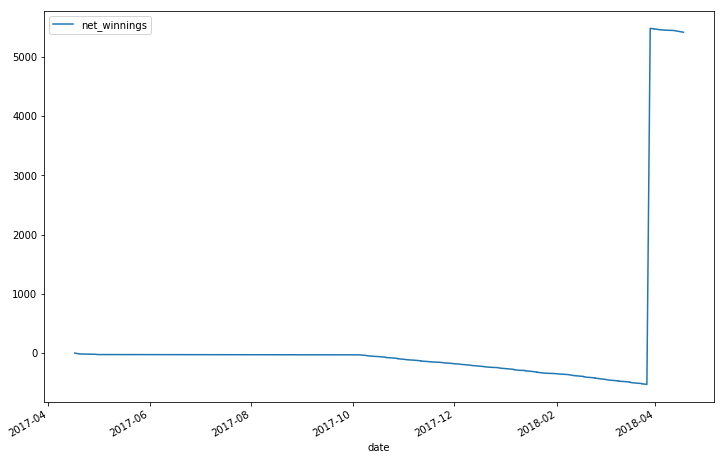

In [34]:
results_for_plot = card_outcomes[['date', 'net_winnings']].copy()
results_for_plot.set_index('date').plot(figsize=(12,8))